# Homework 5

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas.plotting import scatter_matrix

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, Normalizer
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score, precision_score, recall_score, mean_absolute_error

### Exercise 1 & 2

Before starting the exercise for each dataset, let's write general functions for preprocessing and training, after that we can test a lot of different things (strategies, methods etc) with few lines. And our code wil be more efficient

In [32]:
def preprocessing(strategy_num, num_columns, cat_columns, scaling_strategy):
    if scaling_strategy == 'sdscaler':
        sc_strategy = StandardScaler()
    elif scaling_strategy == 'minmaxscaler':
        sc_strategy = MinMaxScaler()
    else:
        print("Please enter one of scaling strategy: standard_scaler, minmaxscaler")
        return
    num_transformer = Pipeline(steps = [
        ('imputer', SimpleImputer(strategy = strategy_num)),
        ('scaling_strategy', sc_strategy)
    ])
    cat_transformer = Pipeline(steps = [
        ('imputer', SimpleImputer(strategy = 'most_frequent')),
        ('one_hot_encoder', OneHotEncoder())
    ])
    col_transformer = ColumnTransformer(transformers =[
        ('numeric_transformer', num_transformer, num_columns),
        ('categorical_transformer', cat_transformer, cat_columns)
    ])
    return col_transformer

In [33]:
def model_func(method = None, problem = None, n_neighbors = None, max_depth = None):
    if(method == 'decision_tree'):
        if(problem == 'classification'):
            return DecisionTreeClassifier(max_depth =  max_depth)
        elif(problem == 'regression'):
            return DecisionTreeRegressor(max_depth =  max_depth)
        else:
            print("Please enter problem of decision tree as classification or regression")
            return
    elif(method == 'knn'):
        if(problem == 'classification'):
            return KNeighborsClassifier(n_neighbors = n_neighbors)
        elif(problem == 'regression'):
            return KNeighborsRegressor(n_neighbors = n_neighbors)
        else:
            print("Please enter problem of knn as classification or regression")
            return
    print("Please enter method as knn or decision tree")

Now let's load our titanic dataset and do experiment on it

In [34]:
df_titanic = sns.load_dataset('titanic')
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [35]:
X = df_titanic[["pclass", "sex", "age", "sibsp", "parch", 
                "embarked", "adult_male", "deck", "alone"]]
y = df_titanic[["survived"]]

In [36]:
num_columns = ['pclass','age','sibsp','parch']
cat_columns = ['sex','embarked','adult_male','deck','alone']

First, let's create empty dataframe to collect results of experiment

In [37]:
df_res_titanic = pd.DataFrame()

And now let's create our arrays of strategies and methods for testing. We will do 10 test (n_test), that is why both numerical strategies and scaler strategies arrays contain 10 strategies (randomly choiced by me). And lastly, we have another array which contains 10 dictionary which holding information about method and parameters that we want to use. We will use 5 knn and 5 decision tree method with different parameters

In [38]:
n_test = 10
test_num_strategies = ['mean', 'median', 'mean', 'most_frequent', 'median', 
                       'mean','most_frequent','median','mean','most_frequent']
test_sc_strategies = ['sdscaler', 'minmaxscaler' ,'sdscaler', 'minmaxscaler','sdscaler', 'minmaxscaler',
                      'sdscaler','minmaxscaler','sdscaler','minmaxscaler']

test_methods = [
    {'method':'knn', 'problem':'classification', 'n_neighbors': 1, 'max_depth': '-'},
    {'method':'knn', 'problem':'classification', 'n_neighbors': 5, 'max_depth': '-'},
    {'method':'knn', 'problem':'classification', 'n_neighbors': 7, 'max_depth': '-'},
    {'method':'knn', 'problem':'classification', 'n_neighbors': 15, 'max_depth': '-'},
    {'method':'knn', 'problem':'classification', 'n_neighbors': 25, 'max_depth': '-'},
    {'method':'decision_tree', 'problem':'classification', 'n_neighbors': '-', 'max_depth': None},
    {'method':'decision_tree', 'problem':'classification', 'n_neighbors': '-', 'max_depth': 3},
    {'method':'decision_tree', 'problem':'classification', 'n_neighbors': '-', 'max_depth': 5},
    {'method':'decision_tree', 'problem':'classification', 'n_neighbors': '-', 'max_depth': 8},
    {'method':'decision_tree', 'problem':'classification', 'n_neighbors': '-', 'max_depth': 15}
]

Now let's do the main part of this exercise. Here we loop according to the n_test. And every loop we use different train, test split for robustness. Later we assign return object of preprocessing to col_transformer. After we create new model pipe and add steps as col_transformer and our model func with appropriate parameters. Later we fit our model pipe and predict our x_test. And lastly, we add all informations about this model to df_res_titanic dataframe.

In [39]:
for i_test in range(n_test):
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    col_transformer = preprocessing(strategy_num = test_num_strategies[i_test],
                                    scaling_strategy = test_sc_strategies[i_test],
                                    num_columns = num_columns,
                                    cat_columns = cat_columns)
    model_pipe = Pipeline(steps = [
        ('preprocessing', col_transformer),
        ('model', model_func(method = test_methods[i_test]['method'], 
                             problem = test_methods[i_test]['problem'],
                             n_neighbors = test_methods[i_test]['n_neighbors'], 
                             max_depth = test_methods[i_test]['max_depth']))
    ])
    model_pipe.fit(X_train,np.ravel(y_train))
    y_pred = model_pipe.predict(X_test)
    df_res_titanic = df_res_titanic.append({'Test': i_test+1,'num_column_strategy':test_num_strategies[i_test],
                                            'cat_column_strategy':'most_frequent',
                                            'scaling_strategy':test_sc_strategies[i_test], 
                                            'method':test_methods[i_test]['method'],
                                            'max_depth':test_methods[i_test]['max_depth'],
                                            'n_neighbors':test_methods[i_test]['n_neighbors'],
                                            'accuracy_score':accuracy_score(y_test,y_pred), 
                                            'precision_score':precision_score(y_test,y_pred),
                                            'recall_score':recall_score(y_test,y_pred),
                                            'f1_score':f1_score(y_test,y_pred)},ignore_index=True)

Our test results are ready, but before showing that let's do some processes to dataframe for better visualizing.

In [40]:
df_res_titanic = df_res_titanic[['Test','num_column_strategy','cat_column_strategy','scaling_strategy',
                                 'method','max_depth','n_neighbors',
                                 'accuracy_score','precision_score','recall_score','f1_score']]
df_res_titanic['Test'] = df_res_titanic['Test'].astype(int)
df_res_titanic = df_res_titanic.set_index('Test')
df_res_titanic

,num_column_strategy,cat_column_strategy,scaling_strategy,method,max_depth,n_neighbors,accuracy_score,precision_score,recall_score,f1_score
Test,,,,,,,,,,
1,mean,most_frequent,sdscaler,knn,-,1.0,0.780269,0.693182,0.734940,0.713450
2,median,most_frequent,minmaxscaler,knn,-,5.0,0.816143,0.661538,0.693548,0.677165
3,mean,most_frequent,sdscaler,knn,-,7.0,0.798206,0.728571,0.662338,0.693878
4,most_frequent,most_frequent,minmaxscaler,knn,-,15.0,0.811659,0.800000,0.711111,0.752941
5,median,most_frequent,sdscaler,knn,-,25.0,0.789238,0.743243,0.662651,0.700637
6,mean,most_frequent,minmaxscaler,decision_tree,None,-,0.757848,0.768293,0.642857,0.700000
7,most_frequent,most_frequent,sdscaler,decision_tree,3,-,0.834081,0.760563,0.729730,0.744828
8,median,most_frequent,minmaxscaler,decision_tree,5,-,0.802691,0.755814,0.738636,0.747126
9,mean,most_frequent,sdscaler,decision_tree,8,-,0.766816,0.698630,0.629630,0.662338


From this dataframe, we can see that all results is close to one another, Let's show dataframe as ascending order of f1_score and accuracy_score.

In [41]:
df_res_titanic.sort_values(by=['f1_score','accuracy_score'],ascending = False)

,num_column_strategy,cat_column_strategy,scaling_strategy,method,max_depth,n_neighbors,accuracy_score,precision_score,recall_score,f1_score
Test,,,,,,,,,,
10,most_frequent,most_frequent,minmaxscaler,decision_tree,15,-,0.834081,0.807692,0.741176,0.773006
4,most_frequent,most_frequent,minmaxscaler,knn,-,15.0,0.811659,0.800000,0.711111,0.752941
8,median,most_frequent,minmaxscaler,decision_tree,5,-,0.802691,0.755814,0.738636,0.747126
7,most_frequent,most_frequent,sdscaler,decision_tree,3,-,0.834081,0.760563,0.729730,0.744828
1,mean,most_frequent,sdscaler,knn,-,1.0,0.780269,0.693182,0.734940,0.713450
5,median,most_frequent,sdscaler,knn,-,25.0,0.789238,0.743243,0.662651,0.700637
6,mean,most_frequent,minmaxscaler,decision_tree,None,-,0.757848,0.768293,0.642857,0.700000
3,mean,most_frequent,sdscaler,knn,-,7.0,0.798206,0.728571,0.662338,0.693878
2,median,most_frequent,minmaxscaler,knn,-,5.0,0.816143,0.661538,0.693548,0.677165


According to this outcomes, 9th test decision tree max_depth=8 is little bit better than others, but it can also changes. If we run again, we can see that other results can sometimes pass our this best result. Generally, I think if we play little bit with parameters of methods we can get better result than this.

------------------------------------

Now let's start to experiment the regression problem

In [42]:
df_tips = sns.load_dataset("tips")
df_tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [43]:
X = df_tips[['total_bill','sex','smoker','day','time','size']]
y = df_tips[['tip']]

In [44]:
num_columns = ['total_bill','size']
cat_columns = ['sex','smoker','day','time']

First, let's create empty dataframe to collect results of experiment

In [45]:
df_res_tips = pd.DataFrame()

And now as before let's create our arrays of strategies and methods for testing. Logic is exactly same. I will use same n_test and array of strategies, because of that I didn't define them again. I only define test_methods again, because in dictionaries we should change classification to regression.

In [46]:
test_methods = [
    {'method':'knn', 'problem':'regression', 'n_neighbors': 1, 'max_depth': '-'},
    {'method':'knn', 'problem':'regression', 'n_neighbors': 5, 'max_depth': '-'},
    {'method':'knn', 'problem':'regression', 'n_neighbors': 7, 'max_depth': '-'},
    {'method':'knn', 'problem':'regression', 'n_neighbors': 10, 'max_depth': '-'},
    {'method':'knn', 'problem':'regression', 'n_neighbors': 20, 'max_depth': '-'},
    {'method':'decision_tree', 'problem':'regression', 'n_neighbors': '-', 'max_depth': None},
    {'method':'decision_tree', 'problem':'regression', 'n_neighbors': '-', 'max_depth': 3},
    {'method':'decision_tree', 'problem':'regression', 'n_neighbors': '-', 'max_depth': 5},
    {'method':'decision_tree', 'problem':'regression', 'n_neighbors': '-', 'max_depth': 8},
    {'method':'decision_tree', 'problem':'regression', 'n_neighbors': '-', 'max_depth': 15}
]

Now let's do the test part again. Logic is exactly same as before.

In [47]:
for i_test in range(n_test):
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    col_transformer = preprocessing(strategy_num = test_num_strategies[i_test],
                                    scaling_strategy = test_sc_strategies[i_test],
                                    num_columns = num_columns,
                                    cat_columns = cat_columns)
    model_pipe = Pipeline(steps = [
        ('preprocessing', col_transformer),
        ('model', model_func(method = test_methods[i_test]['method'], 
                             problem = test_methods[i_test]['problem'],
                             n_neighbors = test_methods[i_test]['n_neighbors'], 
                             max_depth = test_methods[i_test]['max_depth']))
    ])
    model_pipe.fit(X_train,y_train)
    y_pred = model_pipe.predict(X_test)
    df_res_tips = df_res_tips.append({'Test': i_test+1,'num_column_strategy':test_num_strategies[i_test],
                                      'cat_column_strategy':'most_frequent',
                                      'scaling_strategy':test_sc_strategies[i_test], 
                                      'method':test_methods[i_test]['method'],
                                      'max_depth':test_methods[i_test]['max_depth'],
                                      'n_neighbors':test_methods[i_test]['n_neighbors'],
                                      'rmse':np.sqrt(mean_squared_error(y_test,y_pred)),
                                      'mae':mean_absolute_error(y_test,y_pred)},ignore_index=True)

In [48]:
df_res_tips = df_res_tips[['Test','num_column_strategy','cat_column_strategy','scaling_strategy',
                           'method','max_depth','n_neighbors', 'mae','rmse']]
df_res_tips['Test'] = df_res_tips['Test'].astype(int)
df_res_tips = df_res_tips.set_index('Test')

In [49]:
df_res_tips.sort_values(by='rmse')

,num_column_strategy,cat_column_strategy,scaling_strategy,method,max_depth,n_neighbors,mae,rmse
Test,,,,,,,,
3,mean,most_frequent,sdscaler,knn,-,7.0,0.696604,0.821758
7,most_frequent,most_frequent,sdscaler,decision_tree,3,-,0.684729,0.922228
5,median,most_frequent,sdscaler,knn,-,20.0,0.708311,0.950639
8,median,most_frequent,minmaxscaler,decision_tree,5,-,0.798057,1.090497
6,mean,most_frequent,minmaxscaler,decision_tree,None,-,0.918525,1.287977
4,most_frequent,most_frequent,minmaxscaler,knn,-,10.0,0.978770,1.320774
2,median,most_frequent,minmaxscaler,knn,-,5.0,1.040885,1.511336
9,mean,most_frequent,sdscaler,decision_tree,8,-,1.147602,1.523925
10,most_frequent,most_frequent,minmaxscaler,decision_tree,15,-,1.121803,1.663375


From the results of experiments we can see that results are close to each other, but decision tree with max_depth=5, parameter is little bit good than others. As before, if we run again other results can pass our best result. In general, the result is not good, I think it is because of noisy data, and also parameters of model. I think if we play little bit with them we can get better accuracy than this.

### Exercise 3

Now let's start do EDA and make model with diamond dataframe

In [50]:
df_diamonds = sns.load_dataset("diamonds")
df_diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Now let's start to do EDA process to our dataframe. First, let's print general information about dataframe

In [51]:
df_diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


From here we can see that there is not any nan values, it means we don't need to use imputer for both numerical and categorical values.

Now let's print our correlation matrix and see correlation of numerical features to each other.

In [52]:
df_diamonds.corr()

,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


Let's plot this matrix as heatmap for  better visualizing

<AxesSubplot:>

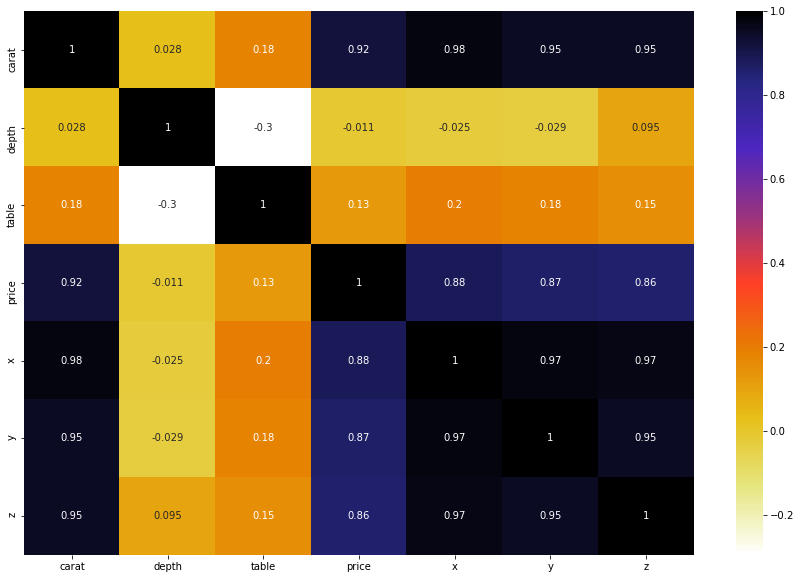

In [53]:
plt.subplots(figsize = (15, 10))
sns.heatmap(df_diamonds.corr(), annot = True, cmap = 'CMRmap_r')

From heatmap and also correlation matrix, we can see that carat has strongest, x, y and z strong correlation to price. Others (depth,table) have less correlation to price.

Now let's show as plot correlation of numerical features

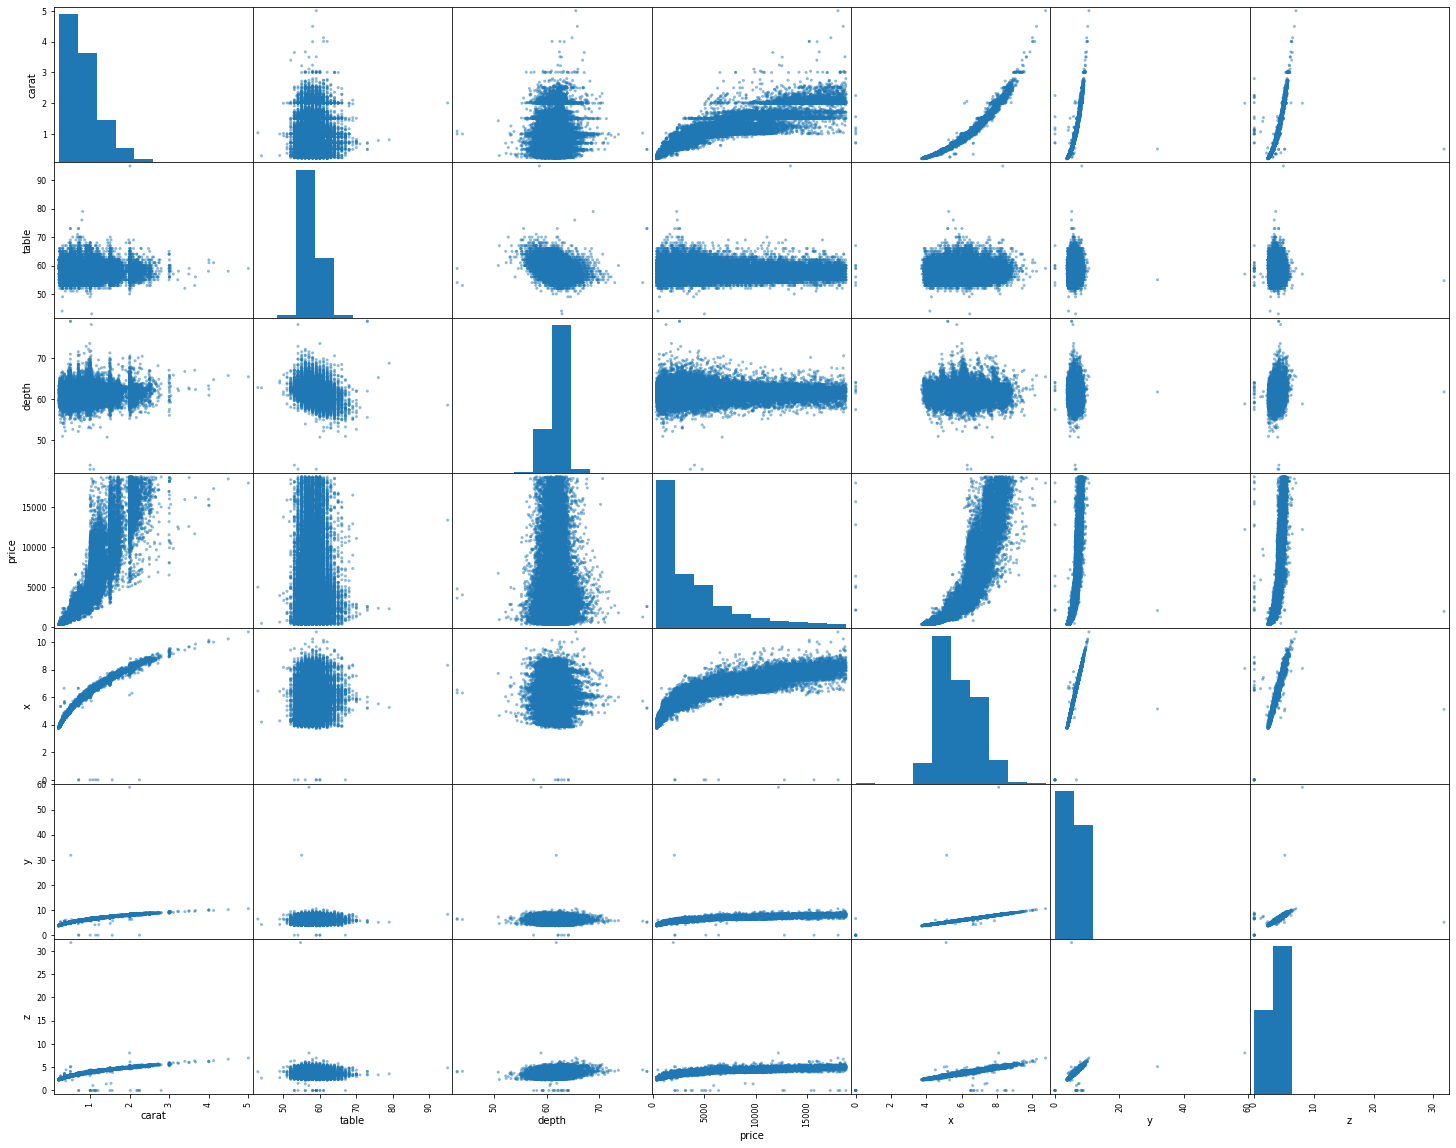

In [54]:
attributes = ["carat","table", "depth","price","x", "y", "z"]
scatter_matrix(df_diamonds[attributes], figsize=(25, 20))
plt.show()

Also from here we can see that the depth and table have very less correlation to price, that is why we can ignore them for predicting the price in our model.

Now let's visualize some categorical features and see relationship

<AxesSubplot:title={'center':'The barplot of clarity versus carat'}, xlabel='carat', ylabel='clarity'>

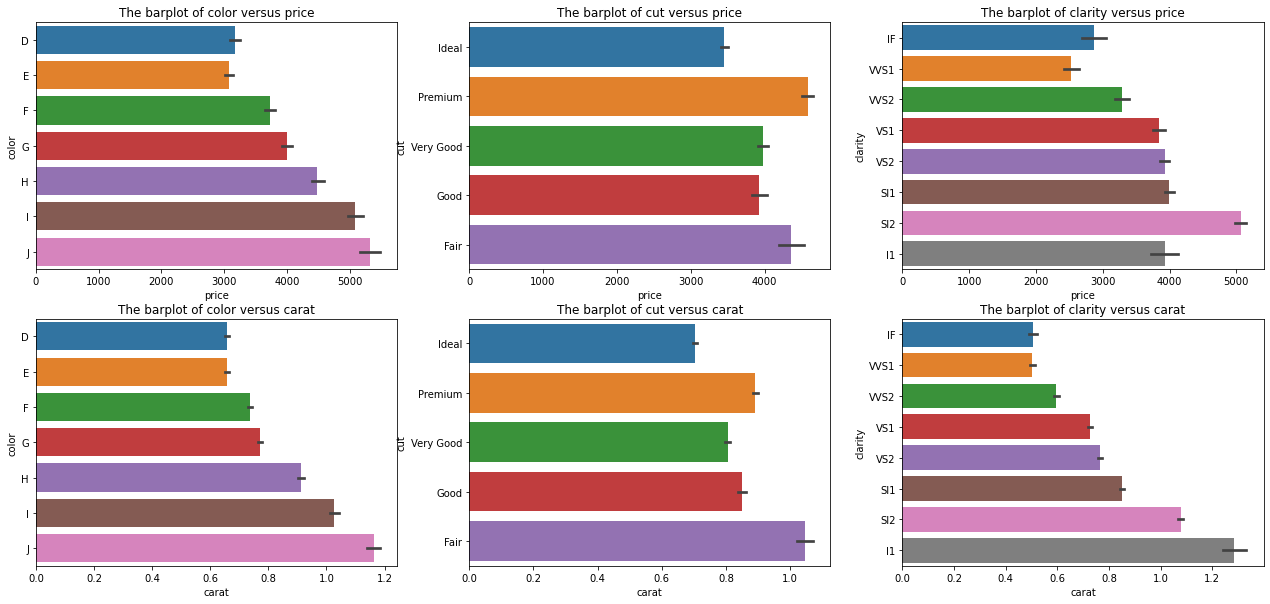

In [55]:
fig, axs = plt.subplots(2,3, figsize = (22,10))

#Color versus price and carat
axs[0][0].set_title("The barplot of color versus price")
sns.barplot(x = df_diamonds.price, y = df_diamonds.color, ax = axs[0][0])
axs[1][0].set_title("The barplot of color versus carat")
sns.barplot(x = df_diamonds.carat, y = df_diamonds.color, ax = axs[1][0])

#Cut versus price and carat
axs[0][1].set_title("The barplot of cut versus price")
sns.barplot(x = df_diamonds.price, y = df_diamonds.cut, ax = axs[0][1])
axs[1][1].set_title("The barplot of cut versus carat")
sns.barplot(x = df_diamonds.carat, y = df_diamonds.cut, ax = axs[1][1])

#Clarity versus price and carat
axs[0][2].set_title("The barplot of clarity versus price")
sns.barplot(x = df_diamonds.price, y = df_diamonds.clarity, ax = axs[0][2])
axs[1][2].set_title("The barplot of clarity versus carat")
sns.barplot(x = df_diamonds.carat, y = df_diamonds.clarity, ax = axs[1][2])

Here we can see that  last one (J) have most carat and at the same time most priced. These two plots are very similar, and all this shows that the color is dependent with price, so we should keep it at X. In second column, we can see that Premium has less carat than Fair but it is most expensive. And also Ideal has least carat and also least price. We can see lots of correlation here, and all it shows that cut also should be considered at predicting price. In third column, we can also see that I1  has most carat, but it is not expensive. Also SI2 is most expensive, and it is 2nd place in carat. All this shows that clarity also affects to price. As a result, in my opinion, color, cut and clarity could let us learn patterns for price, so let's keep them.

I think it is enought to do EDA in our dataframe, let's start to training phase. First let's split our dataframe as X and y. Because of result of experiments, we don't take table and deck as features. 

In [56]:
X = df_diamonds[["carat","cut", "color","clarity","x", "y", "z"]]
y = df_diamonds[["price"]]

In [57]:
num_columns = ["carat","x","y","z"]
cat_columns = ["cut","color","clarity"]

Let's split our X and y data for training and testing.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

Now let's create our general pipeline which consists of both preprocessing and model steps.

In [59]:
model = Pipeline(steps = [
    ("preprocessing", ColumnTransformer(transformers = [
        ("num_columns", StandardScaler(), num_columns),
        ("cat_columns", OneHotEncoder(), cat_columns)
    ])),
    ("model", DecisionTreeRegressor(max_depth=13))
])

In [60]:
model.fit(X_train, y_train)
df_result = pd.DataFrame(data={"model":"Decision Tree",
                          "max_depth":13,
                          "mae": mean_absolute_error(y_test, model.predict(X_test)).round(2),
                          "rmse": np.sqrt(mean_squared_error(y_test,model.predict(X_test))).round(2)},index = [0])

In [61]:
df_result

,model,max_depth,mae,rmse
0,Decision Tree,13,343.22,670.71


From the result dataframe, we can see the value of mae and rmse. I tried a lot of max_depth paramaters, but best I could find is this one (max_depth = 13).

Lastly let's plot scatter plot which show relationship between y_test and y_pred

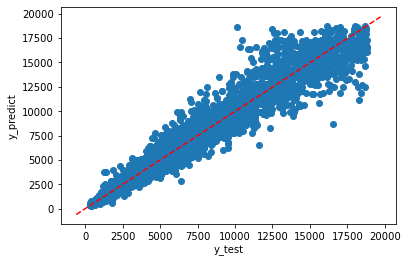

In [62]:
plt.scatter(y_test, model.predict(X_test))
plt.plot(plt.xlim(), plt.ylim(), "--", c = 'r')
plt.xlabel('y_test')
plt.ylabel('y_predict')
plt.show()

Also from plot we can see that our model predict close to ground true except some numbers